In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

Κλάση Ρομπότ για την γέννηση των ρομπότ. Κάθε προσομοίωση έχει 1 ρομπότ συνήθως, με 1-4 κεραίες.

In [8]:
class Robot:
    def __init__(self,pos:np.ndarray,antennas:list):
        self.antennas = antennas
        self.position = pos
        self.num_of_antennas = len(antennas)
    def update_pos(self,pos):
        self.position = pos

Κλάση Tag για τη γέννηση των tags. Κάθε προσομοίωση έχει 1 tag.

In [9]:
class Tag:
    def __init__(self,pos:np.ndarray):
        self.position = pos

Κλάση Antenna για τις κεραίες των ρομπότ.

In [10]:
class Antenna:
    def __init__(self,z:float,G_dBm:float,theta_vector:np.ndarray,phi_vector:np.ndarray):
        self.z = z
        self.G_dBm = G_dBm
        self.theta_vector = theta_vector
        self.phi_vector = phi_vector
        self.phase_bias = random.uniform(0,2*np.pi)
    
    def get_gain(self,theta_rad:float,phi_rad:float):
        theta_deg: int = round(theta_rad*180/np.pi)%360 #we don't really need the modulo here, i think but just to be safe
        phi_deg: int = round(phi_rad * 180/np.pi)%360
        return self.theta_vector[theta_deg] + self.phi_vector[phi_deg] + self.G_dBm


Ξεκινάμε το simulation 

In [11]:
#We assume the RFID tag frequency is 866MHz
freq = 866e6
#Speed of light
c = 299792458.0

lambda_signal = c/freq


Pt_dBm = 30

G_R_dBm = 1

#antenna initialization
pattern = pd.read_excel("pattern.xlsx")
gain_theta = pattern["Gain_t(dB)"].to_numpy()
gain_phi = pattern["Gain_p(dB)"].to_numpy()
Antenna1 = Antenna(0.2,4,gain_theta,gain_phi)
Antenna2 = Antenna(0.4,4,gain_theta,gain_phi)
Antenna3 = Antenna(0.6,4,gain_theta,gain_phi)

#Points of the movement (for the moment it is straight)
p1 = np.array([0,0,0])
p2 = np.array([4,0,0])
#Initialization of robot with antennas
Robot_inst = Robot(p1,[Antenna1,Antenna2])
#p3 serves as a visual guide to know where the movement starts
kappa = 0.1
p3 = (1-kappa)*p1+kappa*p2


data_list = []  #list containing all the saved data
#tag position params
x_tag = 2 
z_tag = 0.1
y_steps = np.linspace(0.1,3,1000) #the last number is the number of samples for each epoch
for antenna_num,antenna in enumerate(Robot_inst.antennas):
    #do this for all antennas
    for y_tag in y_steps:
        #Tag initialization
        tagp = np.array([x_tag,y_tag,z_tag])
        tag1 = Tag(tagp)
        
        phases = []
        robot_pos = []
        rho = 0   #rho is the position of the x axis
        mu,sigma = 0.0038,0.001834  #mu and sigma for the normal distribution of the sampling based on real data. This can change depending on the data.
        while(rho<4):
        #for j in range(0,1000):
            rho = rho + np.random.normal(mu,sigma)
            #there will be a problem with z if p1 and p2 do not have z = 0
            new_pos = p1 + rho*(p2-p1)/np.linalg.norm(p2-p1)
            #new_pos = p1 + j*(p2-p1)/np.linalg.norm(p2-p1)
            robot_pos.append(new_pos)
            Robot_inst.update_pos(new_pos)
            r = np.linalg.norm(tag1.position-Robot_inst.position)
            #Find the phi,theta of the antenna pattern and move it from -pi,pi to 0,2pi
            if(tag1.position[0] == 0):
                theta_tag = np.pi/2
            else:
                theta_tag = np.atan(tag1.position[1]/tag1.position[0])
            theta_tag = (theta_tag + 2*np.pi)%np.pi
            if(tag1.position[2] == antenna.z):
                phi_tag = 0
            else:
                phi_tag = np.atan(np.sqrt(pow(tag1.position[0],2)+pow(tag1.position[1],2))/(tag1.position[2]-antenna.z))
            phi_tag = (phi_tag + 2*np.pi)%np.pi
            #we calculate the Friis equation
            Pr = antenna.get_gain(theta_tag,phi_tag) + G_R_dBm + Pt_dBm + 20*np.log10(lambda_signal/(4*np.pi*r))
            phases.append( ((2*np.pi)/lambda_signal)*2*r + antenna.phase_bias + np.random.normal(0,0.09)) #mu = 0 and sigma = 5deg ~= 0.09 rad
        data_list.append({
            "tag_pos": np.array([x_tag,y_tag,z_tag]),
            "Antenna": antenna_num,
            "robot_pos" : np.array(robot_pos),
            "Phases": np.array(phases)-phases[0]
        })
    
    ##VISUALIZATION

    # fig = plt.figure()
    # plt.scatter(np.array([p1[0],p3[0],p2[0],tagp[0]]),np.array([p1[1],p3[1],p2[1],tagp[1]]))
    # plt.show()
    
    # fig = plt.figure()
    # x = np.arange(0,len(phases))
    # plt.scatter(x,np.array(phases)-phases[0])
    # plt.show()

    # fig = plt.figure()
    # x = np.arange(0,len(phases))
    # plt.scatter(x,np.array(phases)%(2*np.pi),linewidths=0.2)
    # plt.show()

    # fig = plt.figure()
    # plt.plot(gain_theta)
    # plt.plot(gain_phi)
    # plt.show()

# Convert the list to a DataFrame
Data = pd.DataFrame(data_list)

# Save to a pickle file
Data.to_pickle("Sim_Data_Noisy.pkl")





In [12]:
#Data = pd.read_pickle("Sim_Data_Noisy.pkl")
tag_pos = np.vstack(Data['tag_pos'].to_numpy())
antenna_nums = np.vstack(Data['Antenna'].to_numpy())
print(tag_pos.shape)

(2000, 3)


Έπειτα δημιουργούμε έναν πίνακα (tensor) διαστάσεων $(1000, 1000, 4)$ που περιέχει για τα 1000 tags που δημιουργήθηκαν από το simulation, τα 1000 time samples από το μήκος των μετρήσεων, και τα 4 χαρακτηριστικά που μας χρειάζονται , [x_robot,y_robot,z_robot,phase_unwrapped].

***

### Data Augmentation μέσω segmentation

Ορίζουμε την συνάρτηση παρακάτω μέσω της οποίας μετασχηματίζουμε κάθε μία μέτρηση σε ένα πλήθος x που μπορούμε να διαλέξουμε εμείς με y αριθμό μετρήσεων στο κάθε ένα. Αυτό συμβαίνει καθώς για κάθε ένα tag σπάμε τις μετρήσεις σε x (όχι απαραίτητα μη επικαλυπτόμενες) μετρήσεις μεγέθους y.

In [13]:
#Take random segments of the full array
def sample_random_segments(tensor1, segment_length, num_samples):
    if len(tensor1) < segment_length:
        raise ValueError("Segment length must be smaller than or equal to array length.")
    max_start_index = len(tensor1) - segment_length  # Ensure segment stays within bounds
    start_indices = np.random.randint(0, max_start_index + 1, size=num_samples)
    segments = np.empty((num_samples, segment_length))

    for idx, start in enumerate(start_indices):
        segments[idx] = tensor1[start:start+segment_length] - tensor1[start]
    return segments,start_indices

In [14]:
num_of_samples = 5 # Number of samples per tag
segment_length = 400 # Length of each segment


phase_segments = np.empty((0, segment_length))
x0_indices = np.empty((0),dtype=int)
for i in range(tag_pos.shape[0]):
    temp_info,temp_indx = sample_random_segments(Data.loc[i,'Phases'], segment_length, num_of_samples) 
    phase_segments = np.concatenate((phase_segments, temp_info), axis=0)
    x0_indices = np.hstack((x0_indices,temp_indx))
# Multiply labels
tag_pos = np.repeat(tag_pos, num_of_samples, axis=0)
antenna_nums = np.repeat(antenna_nums, num_of_samples, axis=0)



(10000, 400)
(10000, 3)
[ 89 446 665 ...  76 250   8]


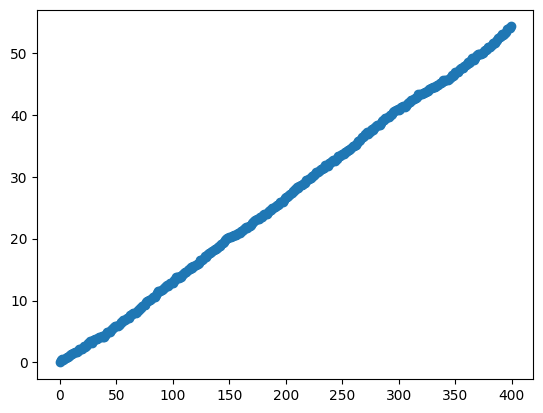

In [15]:
print(phase_segments.shape) 
print(tag_pos.shape)
print(x0_indices)

fig = plt.figure()
x = np.arange(0,len(phase_segments[0]))
plt.scatter(x,np.array(phase_segments[2]))
plt.show()

***

### Linear Interpolation για να έχουμε ίδιο μέγεθος σε όλα τα samples

Μιας και τα δεδομένα μας περιμένουμε να περιέχουν ασυνέχειες, σκεφτόμαστε ότι μέσω της γραμμικής παρεμβολής θα βεβαιωνόμαστε για το σταθερό μήκος του Input στο μοντέλο. Αυτό υλοποιείται παρακάτω.

In [16]:
num_of_samples = 400


robot_pos = np.vstack(Data['robot_pos'].to_numpy())
new_robot_pos = np.empty((0,num_of_samples))
new_phases = np.empty((0,num_of_samples))

data_list = []
for i in range(len(antenna_nums)):
    original_samples = phase_segments[i]
    original_positions = robot_pos[x0_indices[i]:x0_indices[i]+segment_length,0]
    new_positions = np.linspace(original_positions[0],original_positions[-1], num_of_samples)
    new_robot_pos = np.vstack((new_robot_pos,new_positions))
    new_samples = np.interp(new_positions, original_positions, original_samples)
    new_phases = np.vstack((new_phases,new_samples))
    data_list.append({
            "tag_pos": np.array([tag_pos[i,0]-new_robot_pos[i,0],tag_pos[i,1],tag_pos[i,2]]),
            "Antenna": antenna_nums[i],
            "robot_pos" : np.array(new_positions),
            "Phases": np.array(new_samples)
        })

# Convert the list to a DataFrame
Data = pd.DataFrame(data_list)

# Save to a pickle file
Data.to_pickle("Sim_Data_Noisy_Interp.pkl")


In [17]:
print(Data)

                               tag_pos Antenna  \
0       [1.6277210345309387, 0.1, 0.1]     [0]   
1       [0.3497390835921925, 0.1, 0.1]     [0]   
2     [-0.47166634297156707, 0.1, 0.1]     [0]   
3       [0.3470336752916272, 0.1, 0.1]     [0]   
4       [0.4566172528752732, 0.1, 0.1]     [0]   
...                                ...     ...   
9995  [-0.35265900070871403, 3.0, 0.1]     [1]   
9996   [-0.1504715683354001, 3.0, 0.1]     [1]   
9997     [1.675200788310917, 3.0, 0.1]     [1]   
9998     [1.040512907237051, 3.0, 0.1]     [1]   
9999     [1.962578255719454, 3.0, 0.1]     [1]   

                                              robot_pos  \
0     [0.37227896546906136, 0.3759088765417286, 0.37...   
1     [1.6502609164078075, 1.653977513180857, 1.6576...   
2     [2.471666342971567, 2.4754394256226298, 2.4792...   
3     [1.6529663247083728, 1.6566816989337958, 1.660...   
4     [1.5433827471247268, 1.5470612214814325, 1.550...   
...                                          

In [18]:
print(phase_segments.shape)

(10000, 400)


In [19]:
data_list = []
for i in range(len(phase_segments)):
    data_list.append(
        {
            "tag_pos": np.array([tag_pos[i,0]-new_robot_pos[i,0],tag_pos[i,1],tag_pos[i,2]]),
            "Antenna": antenna_num,
            "Phases" : new_phases[i]
        }
    )

# Convert the list to a DataFrame
Data = pd.DataFrame(data_list)

# Save to a pickle file
Data.to_pickle("Sim_Data_Noisy_Interp_Small.pkl")